<a href="https://colab.research.google.com/github/Himanshi771/Generate-resume-by-Himanshi-srivastava/blob/master/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 1. INSTALLATION AND SETUP

This step installs and imports all required libraries for data processing, visualization, machine learning, and deep learning, sets random seeds for reproducibility, suppresses warnings, configures display settings, and verifies the TensorFlow setup and GPU availability to ensure the environment is ready for model training and evaluation.




In [16]:
"""
IEEE-CIS Fraud Detection - Deep Learning Implementation
Multiple Algorithms with Complete Performance Metrics
"""

# ============================================================================
# 1. INSTALLATION AND SETUP
# ============================================================================

# Install required packages
!pip install tensorflow keras scikit-learn pandas numpy matplotlib seaborn plotly imbalanced-learn

# Import libraries
import numpy as np
import pandas as pd
import gc
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, Bidirectional, Attention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1_l2

# Machine Learning
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix,
    classification_report, precision_recall_curve, average_precision_score,
    matthews_corrcoef, cohen_kappa_score, log_loss, fbeta_score
)

# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Set random seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")



✓ Libraries imported successfully!
TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2. LOAD AND PREPARE DATA

This step loads and merges the transaction and identity datasets, checks data size and fraud class distribution, separates IDs and the target variable, and frees memory to prepare the data for modeling.

In [17]:
# 2. LOAD AND PREPARE DATA
# ============================================================================

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

# Merge
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTarget distribution:")
print(train['isFraud'].value_counts(normalize=True))

# Store IDs
train_id = train['TransactionID']
test_id = test['TransactionID']
target = train['isFraud']

del train_transaction, train_identity, test_transaction, test_identity
gc.collect()




LOADING DATA

Train shape: (81704, 434)
Test shape: (83410, 433)

Target distribution:
isFraud
0    0.973147
1    0.026853
Name: proportion, dtype: float64


11498

 3. FEATURE ENGINEERING (SIMPLIFIED FOR SPEED)

This step quickly preprocesses the data by encoding categorical features, filling missing values, reducing feature dimensionality, and preparing clean train and test datasets for modeling.


In [18]:
#============================================================================
# 3. FEATURE ENGINEERING (SIMPLIFIED FOR SPEED)
# ============================================================================

print("\n" + "="*60)
print("FEATU RE ENGINEERING")
print("="*60)

# Combine datasets
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test], axis=0, ignore_index=True)

if 'isFraud' in df.columns:
    df = df.drop('isFraud', axis=1)

# Drop TransactionID
df = df.drop('TransactionID', axis=1)

# Handle categorical columns
print("\nEncoding categorical features...")
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols = [col for col in cat_cols if col != 'is_train']

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('missing')
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# Fill missing values
print("Filling missing values...")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Remove high-cardinality V columns (keep only important ones)
V_cols_to_remove = [f'V{i}' for i in range(1, 340) if f'V{i}' in df.columns]
V_cols_to_keep = [f'V{i}' for i in [12, 13, 34, 56, 78, 90, 127, 258, 279, 307, 317]]
V_cols_to_remove = [col for col in V_cols_to_remove if col not in V_cols_to_keep]
df = df.drop(V_cols_to_remove, axis=1)

print(f"Final feature count: {len(df.columns) - 1}")

# Split back
train = df[df['is_train'] == 1].drop('is_train', axis=1)
test = df[df['is_train'] == 0].drop('is_train', axis=1)

del df
gc.collect()

print(f"\nFinal train shape: {train.shape}")
print(f"Final test shape: {test.shape}")




FEATURE ENGINEERING

Encoding categorical features...
Filling missing values...
Final feature count: 142

Final train shape: (81704, 142)
Final test shape: (83410, 142)


 4. PREPARE DATA FOR DEEP LEARNING

 This step prepares the data for deep learning by separating features and labels, splitting the training data into training and validation sets, and scaling all features for stable model training. It then addresses class imbalance using SMOTE to generate synthetic fraud samples. Finally, the data is reshaped into the required format for CNN and RNN models, making it ready for deep learning architectures.


In [ ]:
# ============================================================================
# 4. PREPARE DATA FOR DEEP LEARNING
# ============================================================================

print("\n" + "="*60)
print("PREPARING DATA FOR DEEP LEARNING")
print("="*60)

# Create X and y
X = train.values
y = target.values
X_test = test.values

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

print(f"\nTrain size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

# Scale the data
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance with SMOTE
print("\nHandling class imbalance with SMOTE...")
print(f"Before SMOTE - Fraud: {y_train.sum()}, Not Fraud: {len(y_train) - y_train.sum()}")

smote = SMOTE(sampling_strategy=0.5, random_state=SEED)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE - Fraud: {y_train_balanced.sum()}, Not Fraud: {len(y_train_balanced) - y_train_balanced.sum()}")

# For CNN and RNN, we need to reshape
input_dim = X_train_scaled.shape[1]
X_train_cnn = X_train_balanced.reshape(X_train_balanced.shape[0], X_train_balanced.shape[1], 1)
X_val_cnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)





PREPARING DATA FOR DEEP LEARNING

Train size: (39584, 142)
Validation size: (9897, 142)
Test size: (49919, 142)

Scaling features...

Handling class imbalance with SMOTE...
Before SMOTE - Fraud: 1082, Not Fraud: 38502
After SMOTE - Fraud: 19251, Not Fraud: 38502


5. PERFORMANCE METRICS FUNCTIONS

This step defines reusable functions to evaluate and visualize model performance. It calculates a wide range of metrics (accuracy, precision, recall, F-scores, AUC, confusion matrix statistics, and more) and provides plotting functions to compare models using bar charts, ROC curves, and confusion matrices, enabling clear and comprehensive performance analysis.

In [20]:
# ============================================================================
# 5. PERFORMANCE METRICS FUNCTIONS
# ============================================================================

def calculate_all_metrics(y_true, y_pred, y_pred_proba):
    """
    Calculate comprehensive performance metrics
    """
    metrics = {}

    # Basic metrics
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, zero_division=0)
    metrics['Recall'] = recall_score(y_true, y_pred, zero_division=0)
    metrics['F1-Score'] = f1_score(y_true, y_pred, zero_division=0)
    metrics['F2-Score'] = fbeta_score(y_true, y_pred, beta=2, zero_division=0)

    # AUC metrics
    metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)
    metrics['PR-AUC'] = average_precision_score(y_true, y_pred_proba)

    # Other metrics
    metrics['Matthews Correlation'] = matthews_corrcoef(y_true, y_pred)
    metrics['Cohen Kappa'] = cohen_kappa_score(y_true, y_pred)
    metrics['Log Loss'] = log_loss(y_true, y_pred_proba)

    # Confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['True Positives'] = tp
    metrics['True Negatives'] = tn
    metrics['False Positives'] = fp
    metrics['False Negatives'] = fn
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['NPV'] = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

    return metrics


def plot_performance_metrics(metrics_dict, title="Model Performance Comparison"):
    """
    Plot comprehensive performance metrics comparison
    """
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Main metrics comparison
    main_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    models = list(metrics_dict.keys())

    data_to_plot = []
    for metric in main_metrics:
        data_to_plot.append([metrics_dict[model][metric] for model in models])

    x = np.arange(len(models))
    width = 0.15

    for i, metric in enumerate(main_metrics):
        axes[0, 0].bar(x + i*width, data_to_plot[i], width, label=metric)

    axes[0, 0].set_xlabel('Models', fontsize=12)
    axes[0, 0].set_ylabel('Score', fontsize=12)
    axes[0, 0].set_title('Main Performance Metrics', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x + width * 2)
    axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # 2. Advanced metrics
    adv_metrics = ['Matthews Correlation', 'Cohen Kappa', 'PR-AUC', 'Specificity']

    data_to_plot2 = []
    for metric in adv_metrics:
        data_to_plot2.append([metrics_dict[model][metric] for model in models])

    for i, metric in enumerate(adv_metrics):
        axes[0, 1].bar(x + i*width, data_to_plot2[i], width, label=metric)

    axes[0, 1].set_xlabel('Models', fontsize=12)
    axes[0, 1].set_ylabel('Score', fontsize=12)
    axes[0, 1].set_title('Advanced Performance Metrics', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(x + width * 1.5)
    axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # 3. F-Scores comparison
    f_metrics = ['F1-Score', 'F2-Score', 'Recall', 'Precision']

    for metric in f_metrics:
        scores = [metrics_dict[model][metric] for model in models]
        axes[1, 0].plot(models, scores, marker='o', label=metric, linewidth=2)

    axes[1, 0].set_xlabel('Models', fontsize=12)
    axes[1, 0].set_ylabel('Score', fontsize=12)
    axes[1, 0].set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)

    # 4. Overall ranking
    # Calculate average of main metrics
    avg_scores = []
    for model in models:
        avg = np.mean([
            metrics_dict[model]['Accuracy'],
            metrics_dict[model]['Precision'],
            metrics_dict[model]['Recall'],
            metrics_dict[model]['F1-Score'],
            metrics_dict[model]['ROC-AUC']
        ])
        avg_scores.append(avg)

    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
    bars = axes[1, 1].barh(models, avg_scores, color=colors)
    axes[1, 1].set_xlabel('Average Score', fontsize=12)
    axes[1, 1].set_title('Overall Model Ranking', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3, axis='x')

    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, avg_scores)):
        axes[1, 1].text(score + 0.01, bar.get_y() + bar.get_height()/2,
                       f'{score:.4f}', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_roc_curves(models_dict, X_val, y_val):
    """
    Plot ROC curves for all models
    """
    plt.figure(figsize=(12, 8))

    for model_name, model in models_dict.items():
        if 'CNN' in model_name or 'LSTM' in model_name or 'GRU' in model_name:
            X_plot = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        else:
            X_plot = X_val

        y_pred_proba = model.predict(X_plot).ravel()
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves - All Models', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.savefig('roc_curves_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrices(models_dict, X_val, y_val):
    """
    Plot confusion matrices for all models
    """
    n_models = len(models_dict)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, (model_name, model) in enumerate(models_dict.items()):
        if 'CNN' in model_name or 'LSTM' in model_name or 'GRU' in model_name:
            X_plot = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        else:
            X_plot = X_val

        y_pred_proba = model.predict(X_plot).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)

        cm = confusion_matrix(y_val, y_pred)

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Not Fraud', 'Fraud'],
                   yticklabels=['Not Fraud', 'Fraud'])
        axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()



MODEL 6: Bidirectional LSTM with Attention

This step creates a Bidirectional LSTM with an attention mechanism that learns important feature patterns from both directions and uses them to improve fraud classification performance.

In [21]:
# ============================================================================
# MODEL 6: Bidirectional LSTM with Attention
# ============================================================================

print("\n6. Building Bidirectional LSTM with Attention...")

def create_bilstm_attention(input_shape):
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    # Attention mechanism (simplified)
    attention = Dense(1, activation='tanh')(x)
    attention = Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(128)(attention)
    attention = layers.Permute([2, 1])(attention)

    sent_representation = layers.Multiply()([x, attention])
    sent_representation = layers.Lambda(lambda xin: tf.keras.backend.sum(xin, axis=1))(sent_representation)

    # Dense layers
    x = Dense(64, activation='relu')(sent_representation)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model

model_bilstm_attention = create_bilstm_attention((input_dim, 1))




6. Building Bidirectional LSTM with Attention...


 7. TRAIN ALL MODELS

 This step creates a Bidirectional LSTM with an attention mechanism that learns important feature patterns from both directions and uses them to improve fraud classification performance.

In [22]:
# ============================================================================
# 7. TRAIN ALL MODELS
# ============================================================================

print("\n" + "="*60)
print("TRAINING ALL MODELS")
print("="*60)

# Store all models
all_models = {
    'Simple DNN': (model_simple_dnn, X_train_balanced, X_val_scaled),
    'Deep DNN': (model_deep_dnn, X_train_balanced, X_val_scaled),
    'CNN': (model_cnn, X_train_cnn, X_val_cnn),
    'LSTM': (model_lstm, X_train_cnn, X_val_cnn),
    'GRU': (model_gru, X_train_cnn, X_val_cnn),
    'BiLSTM-Attention': (model_bilstm_attention, X_train_cnn, X_val_cnn)
}

# Training parameters
EPOCHS = 50
BATCH_SIZE = 512

# Store results
training_histories = {}
trained_models = {}

for model_name, (model, X_tr, X_v) in all_models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    history = model.fit(
        X_tr, y_train_balanced,
        validation_data=(X_v, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    training_histories[model_name] = history
    trained_models[model_name] = model

    print(f"\n✓ {model_name} training completed!")

    # Clear memory
    gc.collect()




TRAINING ALL MODELS

Training Simple DNN
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9798 - auc: 0.9976 - loss: 0.0554 - precision: 0.9648 - recall: 0.9752 - val_accuracy: 0.9714 - val_auc: 0.8641 - val_loss: 0.1137 - val_precision: 0.4800 - val_recall: 0.5778 - learning_rate: 6.2500e-05
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - auc: 0.9981 - loss: 0.0496 - precision: 0.9678 - recall: 0.9781 - val_accuracy: 0.9718 - val_auc: 0.8621 - val_loss: 0.1146 - val_precision: 0.4860 - val_recall: 0.5778 - learning_rate: 6.2500e-05
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9831 - auc: 0.9981 - loss: 0.0477 - precision: 0.9707 - recall: 0.9792 - val_accuracy: 0.9731 - val_auc: 0.8593 - val_loss: 0.1151 - val_precision: 0.5065 - val_recall: 0.5741 - learning_rate: 6.2500e-05
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9817 - auc: 0.9978 - loss: 0.0518 - precision: 0.9671 - recall: 0.9785 - val_accur

8. EVALUATE ALL MODELS

This step evaluates all trained models on the validation dataset by generating predictions, converting probabilities into class labels, and computing comprehensive performance metrics using a unified evaluation function. It automatically selects the correct input shape for each model type, stores all results for comparison, and prints detailed metric summaries and classification reports to clearly assess and compare model performance.

In [23]:
# ============================================================================
# 8. EVALUATE ALL MODELS
# ============================================================================

print("\n" + "="*60)
print("EVALUATING ALL MODELS")
print("="*60)

all_metrics = {}

for model_name, model in trained_models.items():
    print(f"\nEvaluating {model_name}...")

    # Get appropriate data shape
    if 'CNN' in model_name or 'LSTM' in model_name or 'GRU' in model_name or 'BiLSTM' in model_name:
        X_eval = X_val_cnn
    else:
        X_eval = X_val_scaled

    # Predictions
    y_pred_proba = model.predict(X_eval, verbose=0).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate all metrics
    metrics = calculate_all_metrics(y_val, y_pred, y_pred_proba)
    all_metrics[model_name] = metrics

    # Print metrics
    print(f"\n{model_name} Performance:")
    print("-" * 60)
    for metric_name, value in metrics.items():
        if isinstance(value, (int, np.integer)):
            print(f"{metric_name:.<40} {value:>10d}")
        else:
            print(f"{metric_name:.<40} {value:>10.4f}")

    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_val, y_pred, target_names=['Not Fraud', 'Fraud']))




EVALUATING ALL MODELS

Evaluating Simple DNN...

Simple DNN Performance:
------------------------------------------------------------
Accuracy................................     0.9714
Precision...............................     0.4800
Recall..................................     0.5778
F1-Score................................     0.5244
F2-Score................................     0.5552
ROC-AUC.................................     0.8964
PR-AUC..................................     0.5851
Matthews Correlation....................     0.5121
Cohen Kappa.............................     0.5098
Log Loss................................     0.1131
True Positives..........................        156
True Negatives..........................       9458
False Positives.........................        169
False Negatives.........................        114
Specificity.............................     0.9824
NPV.....................................     0.9881

Classification Report for Simple

9. CREATE COMPREHENSIVE COMPARISON

This step consolidates the evaluation results of all models into a single comparison table, rounds the metrics for readability, and saves them for future reference. It then visually compares model performance by plotting comprehensive metric comparisons, ROC curves, and confusion matrices, making it easy to analyze, rank, and select the best-performing fraud detection model.








CREATING PERFORMANCE COMPARISON

📊 COMPLETE PERFORMANCE METRICS COMPARISON:
                  Accuracy  Precision  Recall  F1-Score  F2-Score  ROC-AUC  \
Simple DNN          0.9714     0.4800  0.5778    0.5244    0.5552   0.8964   
Deep DNN            0.9736     0.5151  0.5704    0.5413    0.5584   0.9014   
CNN                 0.9734     0.5110  0.6000    0.5520    0.5798   0.9110   
LSTM                0.9154     0.1669  0.5259    0.2533    0.3677   0.7871   
GRU                 0.9727     0.0000  0.0000    0.0000    0.0000   0.5000   
BiLSTM-Attention    0.9583     0.3260  0.4963    0.3935    0.4494   0.8399   

                  PR-AUC  Matthews Correlation  Cohen Kappa  Log Loss  \
Simple DNN        0.5851                0.5121       0.5098    0.1131   
Deep DNN          0.5915                0.5285       0.5278    0.1213   
CNN               0.6276                0.5402       0.5384    0.0966   
LSTM              0.2754                0.2628       0.2211    0.2434   
GRU        

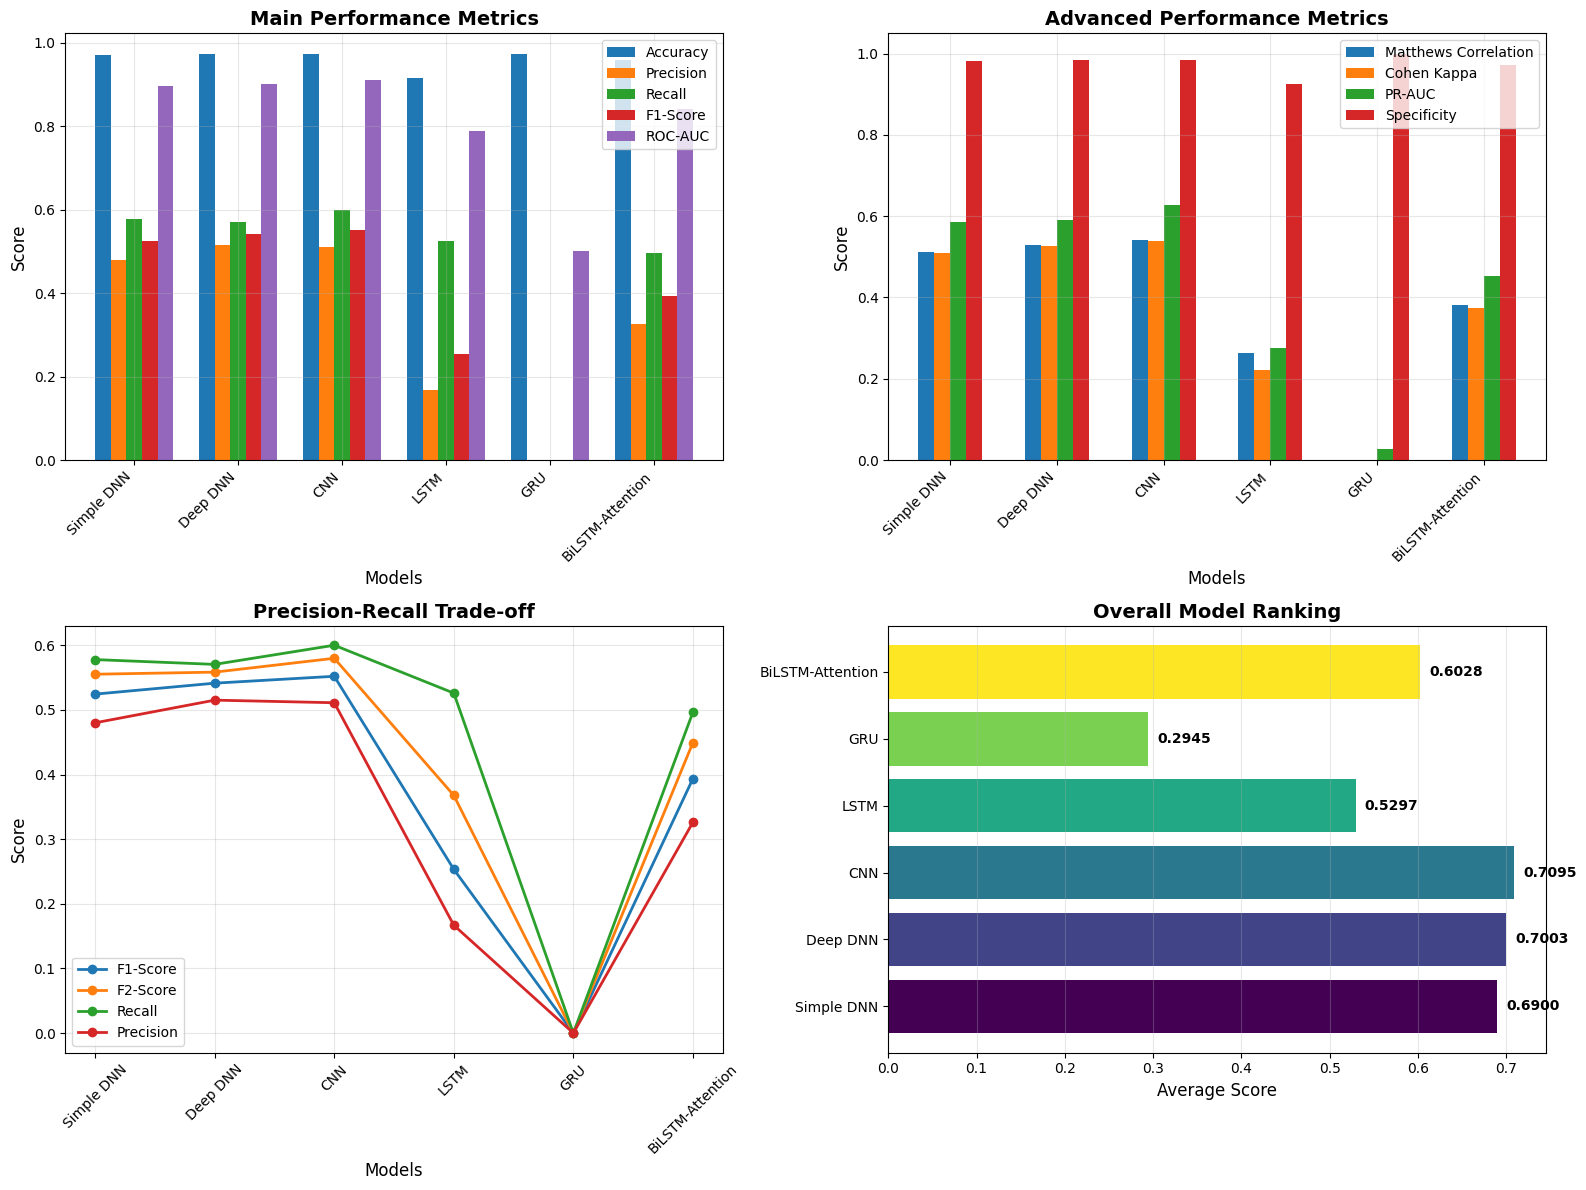

310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


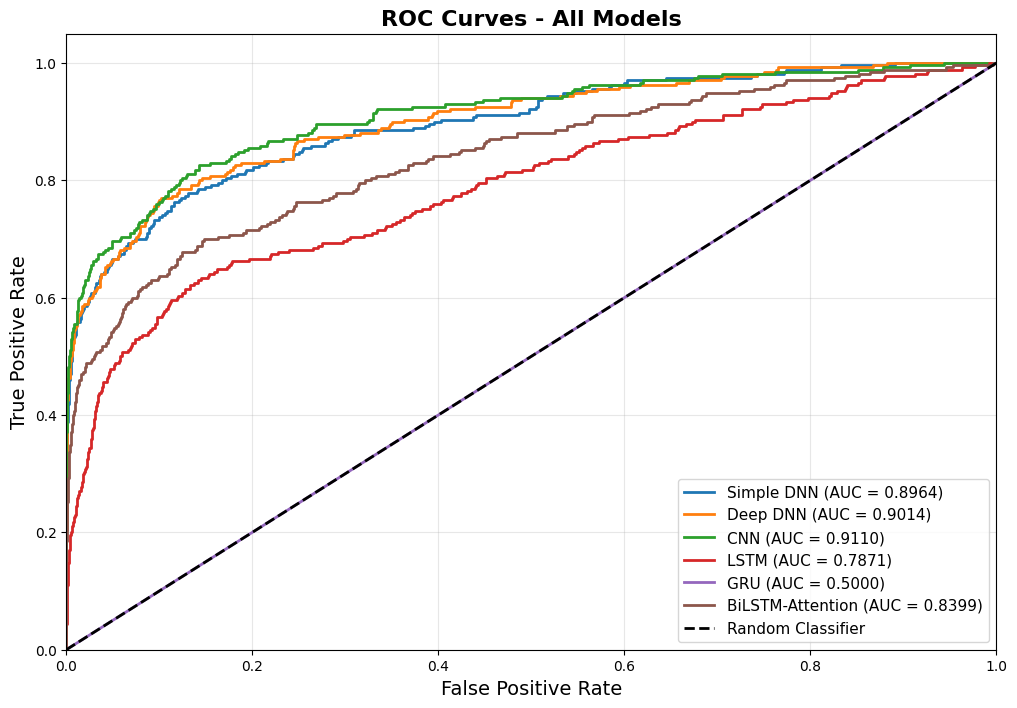

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


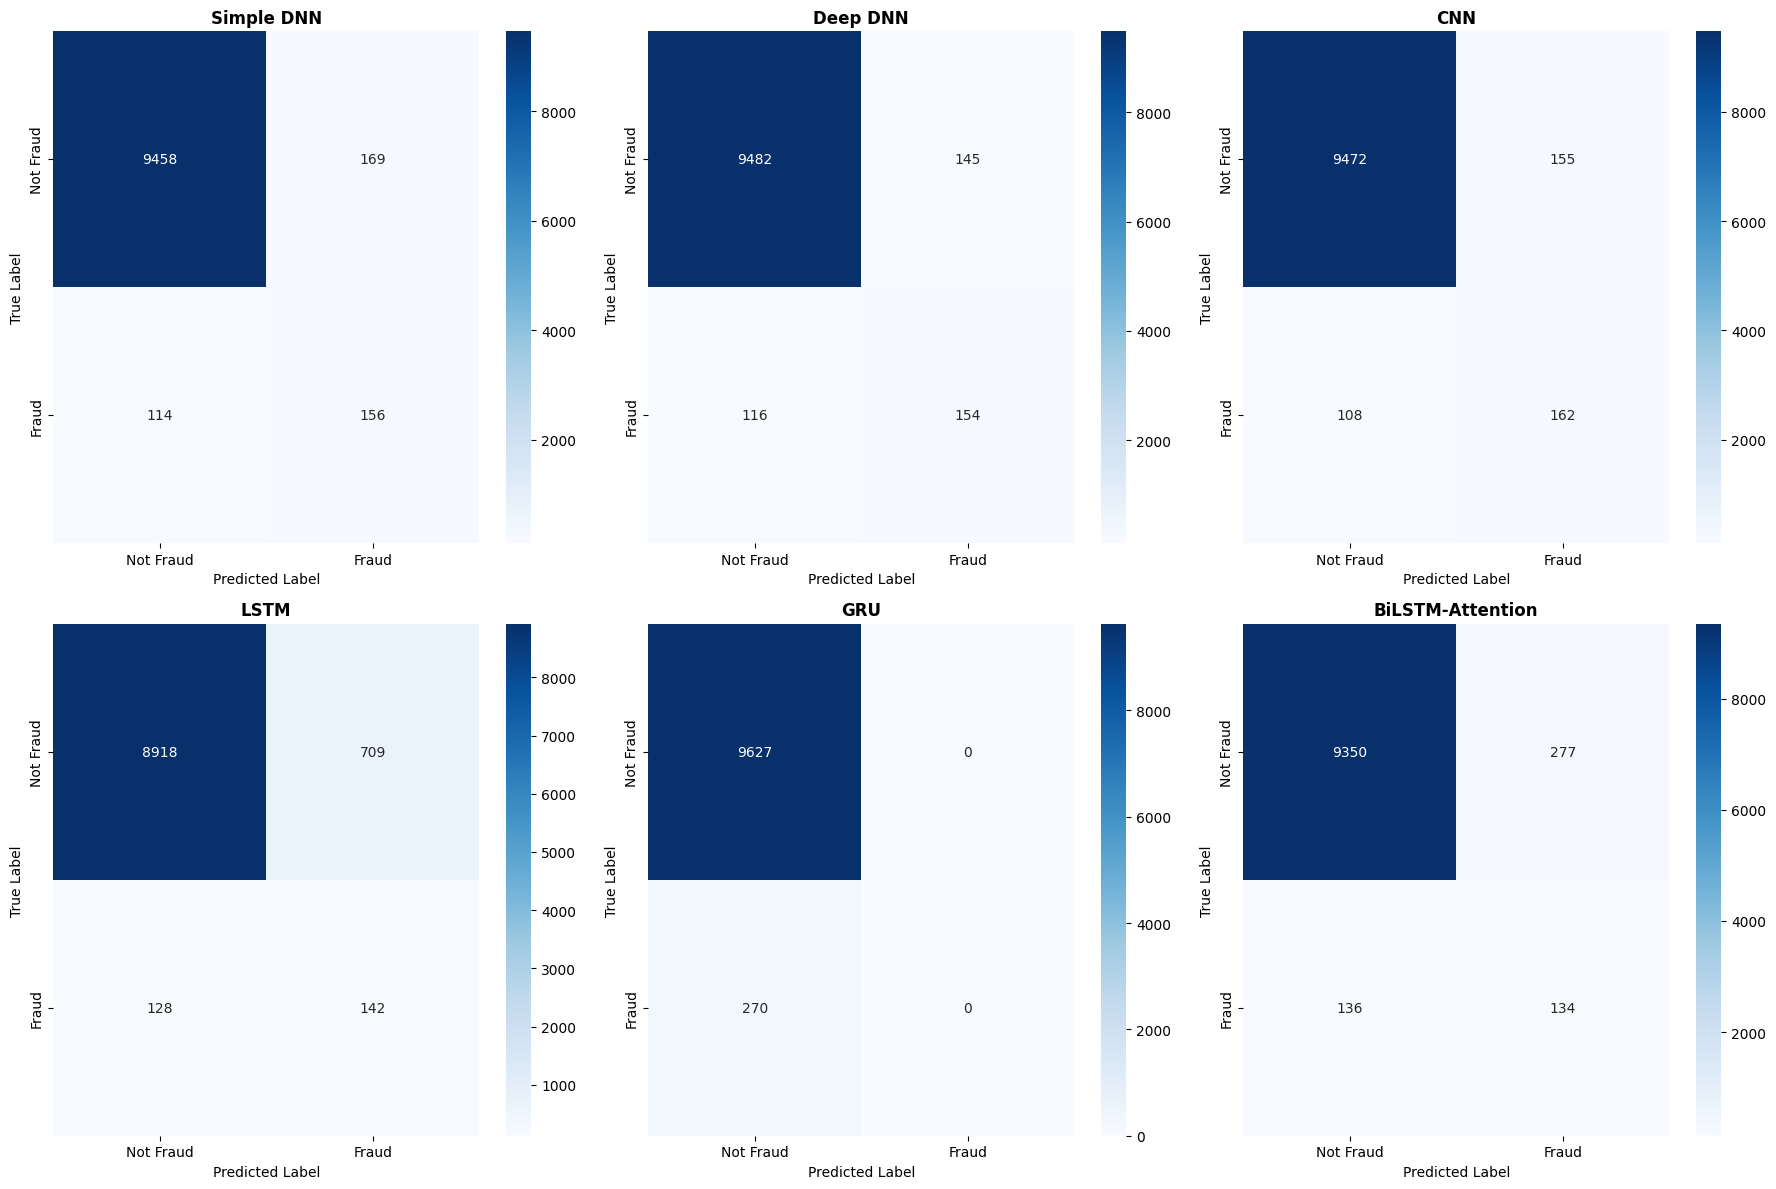

In [24]:
# ============================================================================
# 9. CREATE COMPREHENSIVE COMPARISON
# ============================================================================

print("\n" + "="*60)
print("CREATING PERFORMANCE COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame(all_metrics).T
comparison_df = comparison_df.round(4)

print("\n📊 COMPLETE PERFORMANCE METRICS COMPARISON:")
print("="*80)
print(comparison_df)

# Save to CSV
comparison_df.to_csv('model_performance_comparison.csv')
print("\n✓ Comparison saved to 'model_performance_comparison.csv'")

# Plot comprehensive comparison
plot_performance_metrics(all_metrics)

# Plot ROC curves
plot_roc_curves(trained_models, X_val_scaled, y_val)

# Plot confusion matrices
plot_confusion_matrices(trained_models, X_val_scaled, y_val)



10. IDENTIFY BEST MODEL

This step identifies the best-performing model by ranking all models across multiple key metrics such as accuracy, precision, recall, F1-score, ROC-AUC, PR-AUC, and Matthews correlation. It determines the top model for each metric, then computes an overall ranking based on the average rank across all metrics to select the most consistently strong model. Finally, it reports the complete performance details of the overall best model for clear comparison and final selection.

In [25]:
# ============================================================================
# 10. IDENTIFY BEST MODEL
# ============================================================================

print("\n" + "="*60)
print("FINDING BEST MODEL")
print("="*60)

# Rank by different metrics
rankings = {}

metrics_to_rank = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC', 'Matthews Correlation']

for metric in metrics_to_rank:
    sorted_models = comparison_df.sort_values(by=metric, ascending=False)
    rankings[metric] = sorted_models.index.tolist()
    print(f"\n🏆 Best by {metric}: {sorted_models.index[0]} ({sorted_models[metric].iloc[0]:.4f})")

# Overall best (based on average rank)
rank_scores = {}
for model in comparison_df.index:
    avg_rank = np.mean([rankings[metric].index(model) for metric in metrics_to_rank])
    rank_scores[model] = avg_rank

best_model_name = min(rank_scores, key=rank_scores.get)
print(f"\n" + "="*60)
print(f"🎯 OVERALL BEST MODEL: {best_model_name}")
print(f"="*60)

print(f"\n{best_model_name} Performance:")
for metric, value in all_metrics[best_model_name].items():
    if isinstance(value, (int, np.integer)):
        print(f"  {metric}: {value}")
    else:
        print(f"  {metric}: {value:.4f}")




FINDING BEST MODEL

🏆 Best by Accuracy: Deep DNN (0.9736)

🏆 Best by Precision: Deep DNN (0.5151)

🏆 Best by Recall: CNN (0.6000)

🏆 Best by F1-Score: CNN (0.5520)

🏆 Best by ROC-AUC: CNN (0.9110)

🏆 Best by PR-AUC: CNN (0.6276)

🏆 Best by Matthews Correlation: CNN (0.5402)

🎯 OVERALL BEST MODEL: CNN

CNN Performance:
  Accuracy: 0.9734
  Precision: 0.5110
  Recall: 0.6000
  F1-Score: 0.5520
  F2-Score: 0.5798
  ROC-AUC: 0.9110
  PR-AUC: 0.6276
  Matthews Correlation: 0.5402
  Cohen Kappa: 0.5384
  Log Loss: 0.0966
  True Positives: 162
  True Negatives: 9472
  False Positives: 155
  False Negatives: 108
  Specificity: 0.9839
  NPV: 0.9887


11. PLOT TRAINING HISTORIES

This step visualizes the training process of all models by plotting training and validation loss across epochs. These plots help analyze model convergence, detect overfitting or underfitting, and compare how well each model learned during training.


PLOTTING TRAINING HISTORIES


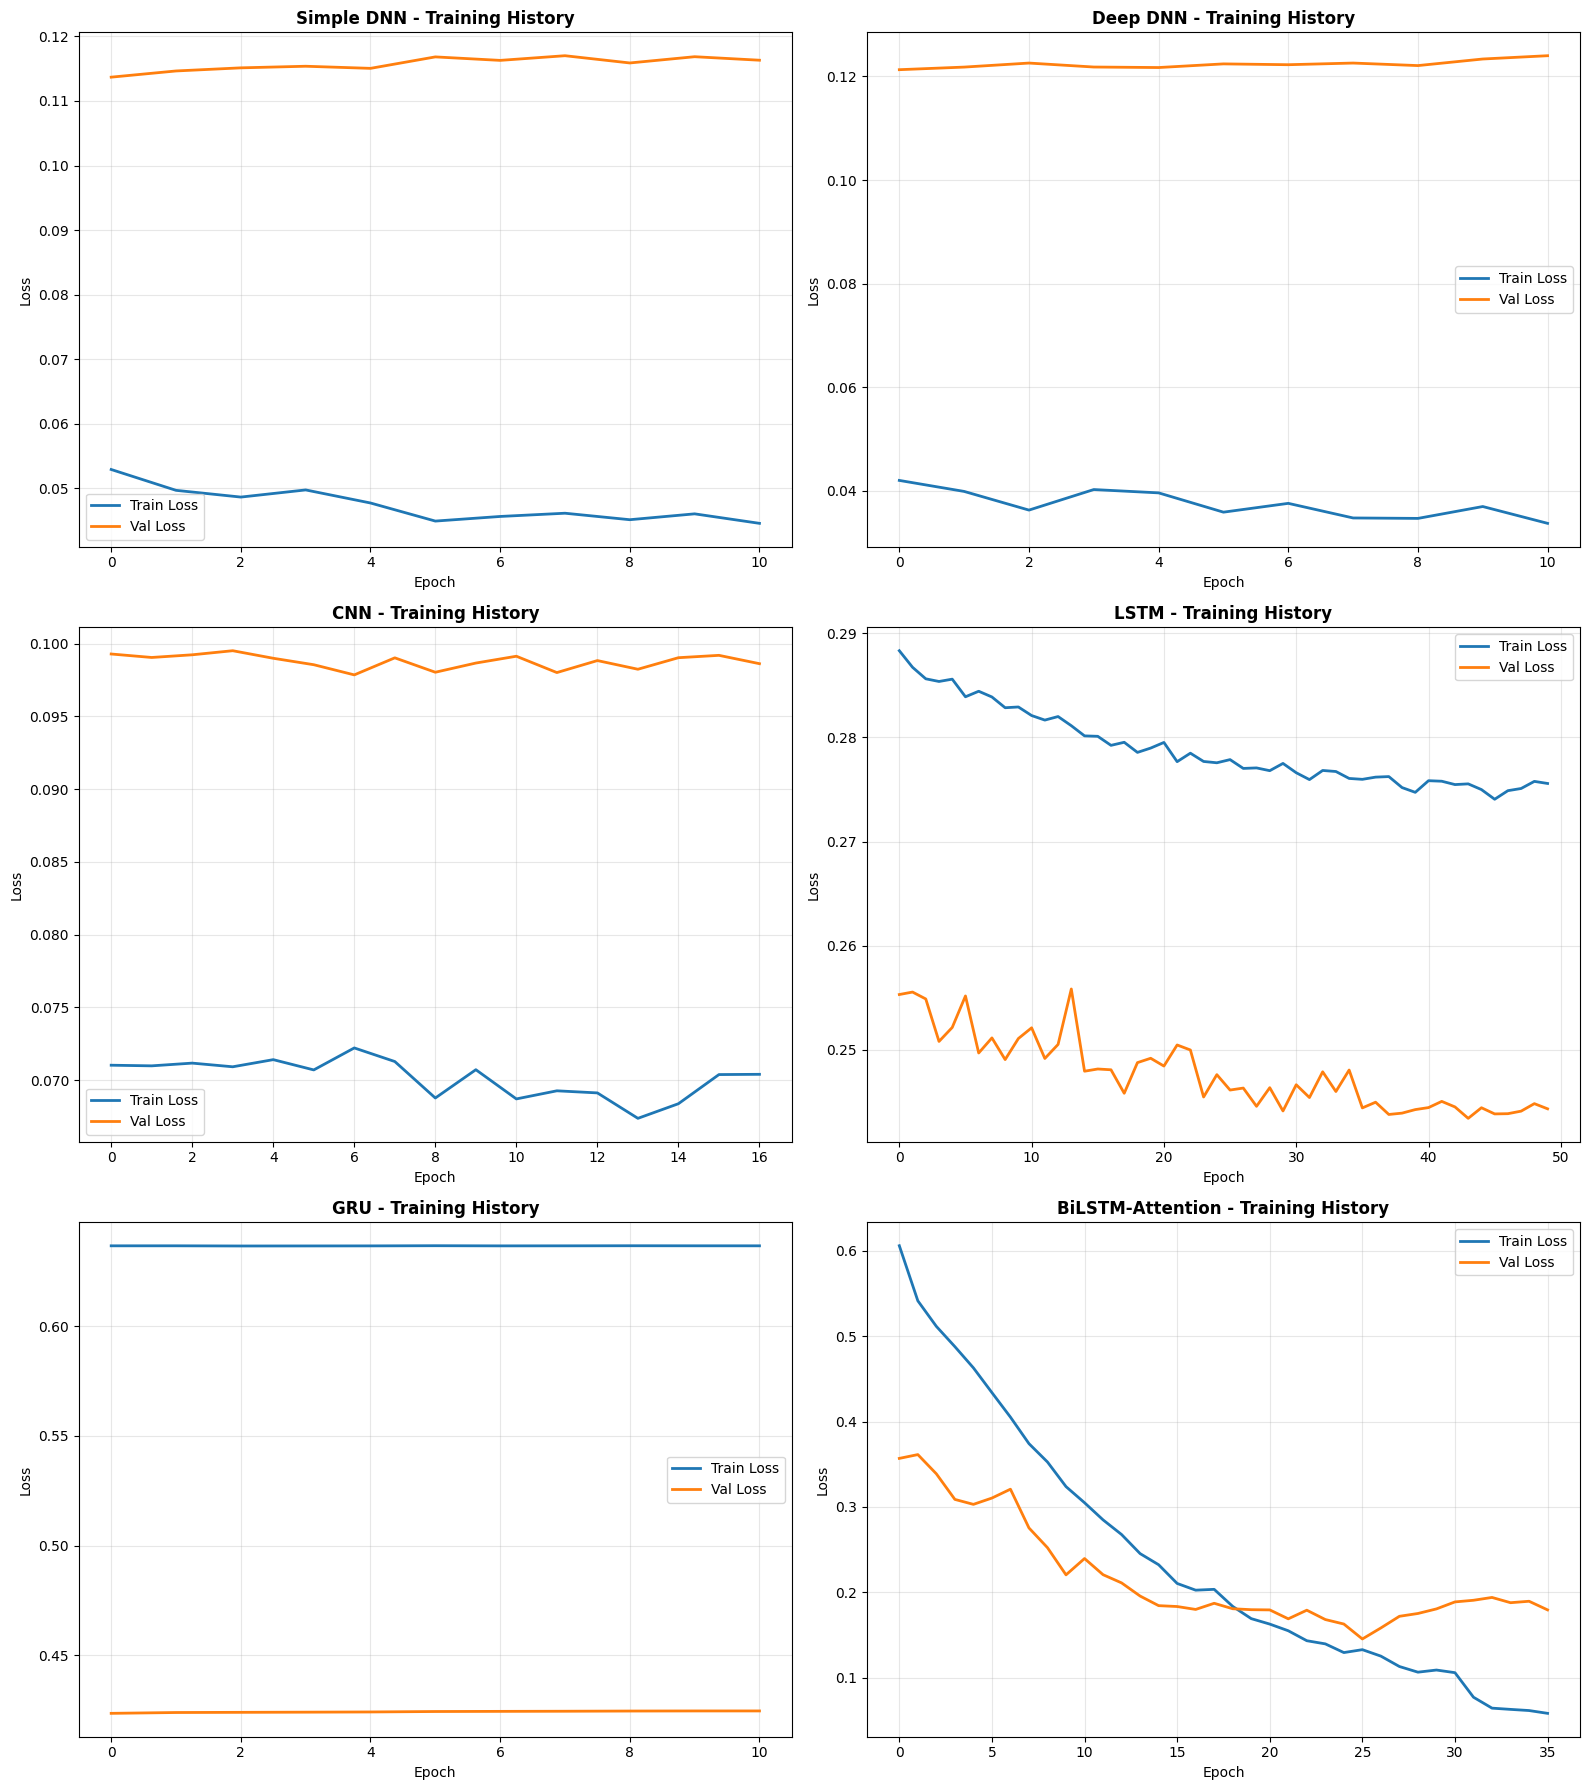

In [26]:
# ============================================================================
# 11. PLOT TRAINING HISTORIES
# ============================================================================

print("\n" + "="*60)
print("PLOTTING TRAINING HISTORIES")
print("="*60)

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.ravel()

for idx, (model_name, history) in enumerate(training_histories.items()):
    # Loss
    axes[idx].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[idx].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[idx].set_title(f'{model_name} - Training History', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_histories.png', dpi=300, bbox_inches='tight')
plt.show()



12. PREDICTIONS ON TEST SET

This step uses the best-performing model to generate predictions on the test set. It first scales and reshapes the test features to match the model’s input format, then predicts fraud probabilities. The results are combined with TransactionID to create a submission file, previewed, and saved as a CSV, ready for evaluation or competition submission.



In [31]:
# ============================================================================
# 12. PREDICTIONS ON TEST SET
# ============================================================================

print("\n" + "="*60)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*60)

best_model = trained_models[best_model_name]

# Re-create scaled and reshaped test data directly from the 'test' DataFrame
# to ensure its length matches 'test_id'.
# 'test' DataFrame has 83410 rows and 'scaler' was fitted in cell 'eV7RZYsJk8rw'.
current_X_test_scaled = scaler.transform(test.values) # Use the global 'test' DataFrame and 'scaler'

if 'CNN' in best_model_name or 'LSTM' in best_model_name or 'GRU' in best_model_name or 'BiLSTM' in best_model_name:
    # Reshape for CNN/RNN models (input_dim is available globally from cell eV7RZYsJk8rw)
    current_X_test_final = current_X_test_scaled.reshape(current_X_test_scaled.shape[0], input_dim, 1)
else:
    current_X_test_final = current_X_test_scaled

# Predictions
test_predictions = best_model.predict(current_X_test_final, verbose=1).ravel()

# Create submission
submission = pd.DataFrame({
    'TransactionID': test_id,
    'isFraud': test_predictions
})

print("\nSubmission preview:")
print(submission.head(10))
print(f"\nPredicted fraud rate: {submission['isFraud'].mean():.4f}")

submission.to_csv(f'fraud_detection_submission_{best_model_name.replace(" ", "_")}.csv', index=False)
print(f"\n✓ Submission saved as 'fraud_detection_submission_{best_model_name.replace(' ', '_')}.csv'")



GENERATING PREDICTIONS ON TEST SET
2607/2607 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

Submission preview:
   TransactionID  isFraud
0        3663549      0.0
1        3663550      0.0
2        3663551      0.0
3        3663552      0.0
4        3663553      0.0
5        3663554      0.0
6        3663555      0.0
7        3663556      0.0
8        3663557      0.0
9        3663558      0.0

Predicted fraud rate: 0.0000

✓ Submission saved as 'fraud_detection_submission_CNN.csv'


13. SAVE BEST MODEL

This step saves the best-performing model to a file in HDF5 format (.h5), preserving its architecture, weights, and training configuration so it can be easily loaded later for inference, further training, or deployment.

In [29]:
# ============================================================================
# 13. SAVE BEST MODEL
# ============================================================================

print("\n" + "="*60)
print("SAVING BEST MODEL")
print("="*60)

best_model.save(f'best_fraud_detection_model_{best_model_name.replace(" ", "_")}.h5')
print(f"✓ Model saved as 'best_fraud_detection_model_{best_model_name.replace(' ', '_')}.h5'")



SAVING BEST MODEL
✓ Model saved as 'best_fraud_detection_model_CNN.h5'
